In [1]:
import numpy as np
import matplotlib.pyplot as plt
from slsim.Util import astro_util
from slsim.Sources.SourceVariability import accretion_disk_reprocessing
from slsim.Sources.SourceVariability import variability
import warnings

warnings.filterwarnings(action="ignore");

# Create a bending power law light curve

In [2]:
# define light curve parameters
length_of_light_curve = 1000  # Days
dt = 1  # Days
mean_magnitude = 10  # magnitude
standard_deviation = 0.2
random_seed = 14  # I am defining a random seed so the light curve is consistent through all realizations

# define bending power law parameters
low_frequency_index = 1
high_frequency_index = 3
log_breakpoint_frequency = -1

bpl_kwarg_dict = {
    "length_of_light_curve": length_of_light_curve,
    "time_resolution": dt,
    "log_breakpoint_frequency": log_breakpoint_frequency,
    "low_frequency_slope": low_frequency_index,
    "high_frequency_slope": high_frequency_index,
    "mean_magnitude": mean_magnitude,
    "standard_deviation": standard_deviation,
    "seed": random_seed,
}

time_stamps, light_curve = astro_util.generate_signal_from_bending_power_law(
    **bpl_kwarg_dict
)

mean: 10.0
standard deviation: 0.19999999116369654


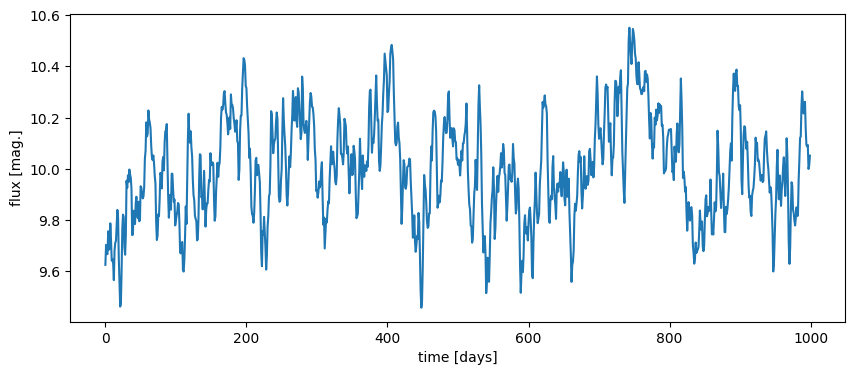

In [3]:
print("mean: " + str(light_curve.mean()))
print("standard deviation: " + str(light_curve.std()))

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_stamps, light_curve)
ax.set_xlabel("time [days]")
ax.set_ylabel("flux [mag.]")
plt.show()

# Create identical light curve using variability module

In [4]:
variable_light_curve = variability.Variability(
    variability_model="bending_power_law", **bpl_kwarg_dict
)

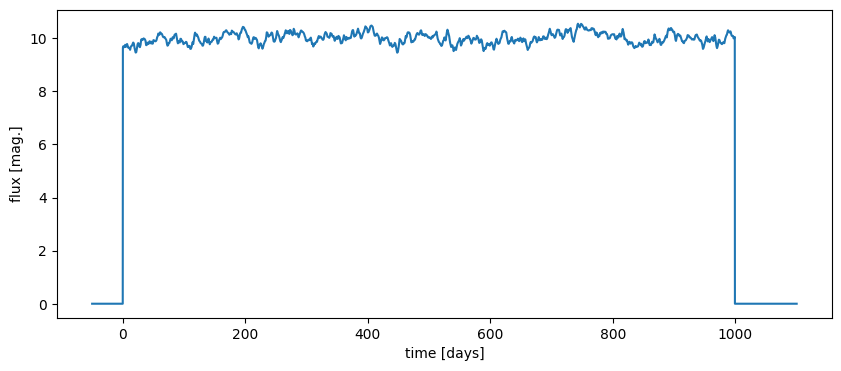

In [5]:
some_time_stamps = np.linspace(-50, 1100, 20000)
interpolated_light_curve = variable_light_curve.variability_at_time(some_time_stamps)
# interpolation to timestamps outside defined light curve default to 0

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(some_time_stamps, interpolated_light_curve)
ax.set_xlabel("time [days]")
ax.set_ylabel("flux [mag.]")
plt.show()

# Create a light curve using a defined power spectrum density

In [6]:
frequencies = astro_util.define_frequencies(length_of_light_curve, dt)
power_spectrum_1 = frequencies ** (
    -3
)  # Note the slope of (-3) suppresses high frequency signals.
power_spectrum_2 = frequencies ** (-1)  # A slope of (-1) becomes very noisy.

other_time_stamps = np.linspace(200, 800, 1000)

psd_kwarg_dict_1 = {
    "length_of_light_curve": length_of_light_curve,
    "time_resolution": dt,
    "input_frequencies": frequencies,
    "input_psd": power_spectrum_1,
    "mean_magnitude": mean_magnitude,
    "standard_deviation": standard_deviation,
    "seed": random_seed,
}
psd_kwarg_dict_2 = {
    "length_of_light_curve": length_of_light_curve,
    "time_resolution": dt,
    "input_frequencies": frequencies,
    "input_psd": power_spectrum_2,
    "mean_magnitude": mean_magnitude,
    "standard_deviation": standard_deviation,
    "seed": random_seed,
}

psd_variable_signal = variability.Variability(
    variability_model="user_defined_psd", **psd_kwarg_dict_1
)
psd_signal_1 = psd_variable_signal.variability_at_time(other_time_stamps)
psd_variable_signal = variability.Variability(
    variability_model="user_defined_psd", **psd_kwarg_dict_2
)
psd_signal_2 = psd_variable_signal.variability_at_time(other_time_stamps)

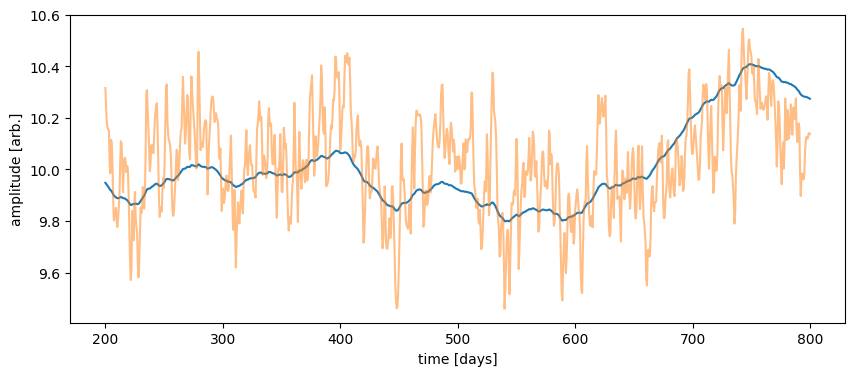

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(other_time_stamps, psd_signal_1)
ax.plot(other_time_stamps, psd_signal_2, alpha=0.5)
ax.set_xlabel("time [days]")
ax.set_ylabel("amplitude [arb.]")
plt.show()

# Use these as an intrinsic signal to be reprocessed

In [8]:
outer_radius_of_accretion_disk = 2000  # R_g = G M_bh / c^2
corona_height = 30  # R_g
r_resolution = 1000  # pixels per outer radius
inclination_angle = 45  # degrees
black_hole_mass_exponent = 9.0
black_hole_spin = 0.3
eddington_ratio = 0.15

agn_kwarg_dict = {
    "r_out": outer_radius_of_accretion_disk,
    "corona_height": corona_height,
    "r_resolution": r_resolution,
    "inclination_angle": inclination_angle,
    "black_hole_mass_exponent": black_hole_mass_exponent,
    "black_hole_spin": black_hole_spin,
    "eddington_ratio": eddington_ratio,
}

agn_reprocessor = accretion_disk_reprocessing.AccretionDiskReprocessing(
    "lamppost", **agn_kwarg_dict
)

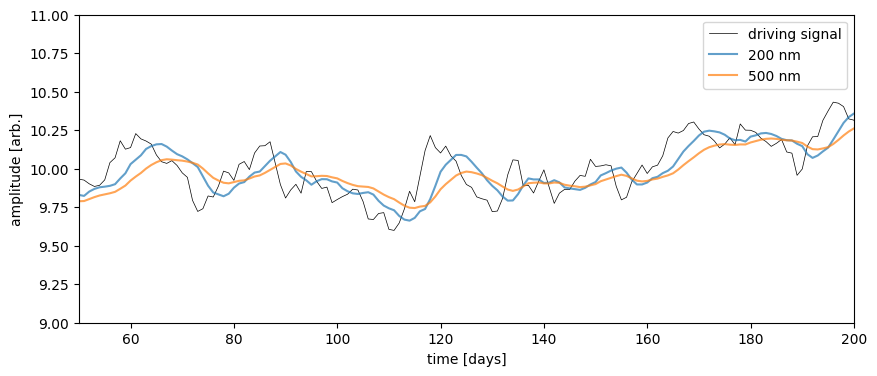

In [9]:
agn_reprocessor.define_intrinsic_signal(
    time_array=time_stamps, magnitude_array=light_curve
)
reprocessed_200nm = agn_reprocessor.reprocess_signal(
    rest_frame_wavelength_in_nanometers=200
)
reprocessed_500nm = agn_reprocessor.reprocess_signal(
    rest_frame_wavelength_in_nanometers=500
)

# Note the earliest times do not have enough signal history built up to generate a reprocessed signal

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_stamps, light_curve, color="black", linewidth=0.5, label="driving signal")
ax.plot(time_stamps, reprocessed_200nm, alpha=0.7, label="200 nm")
ax.plot(time_stamps, reprocessed_500nm, alpha=0.7, label="500 nm")
ax.set_xlabel("time [days]")
ax.set_ylabel("amplitude [arb.]")
ax.set_xlim(50, 200)  # Zoom in on a small region to see delays
ax.set_ylim(9, 11)
ax.legend()
plt.show()

# To understand what these reprocessing functions look like, we may plot them

1.0


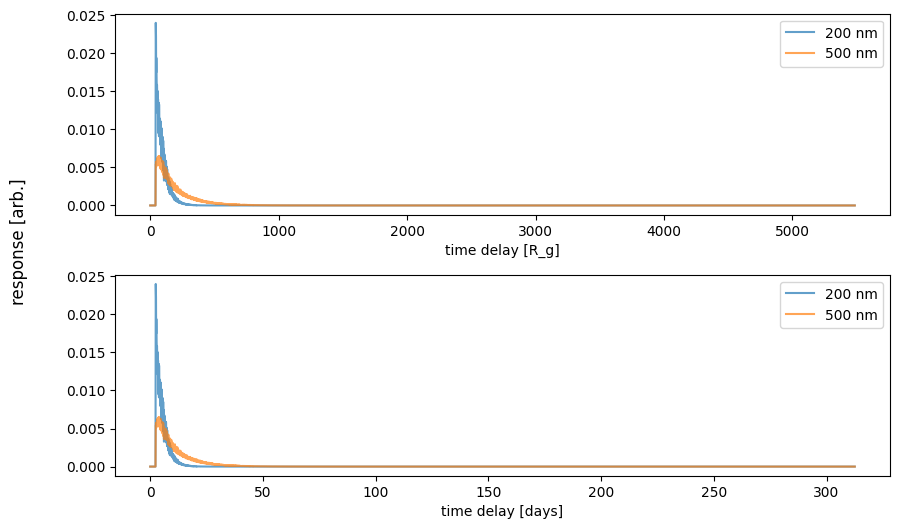

In [10]:
response_function_200nm = agn_reprocessor.define_new_response_function(
    rest_frame_wavelength_in_nanometers=200
)
response_function_500nm = agn_reprocessor.define_new_response_function(
    rest_frame_wavelength_in_nanometers=500
)
# Note the sum of these response function is defined to be 1
# so the convolution doesn't change the amplitudes
print(np.sum(response_function_200nm))

# similar plotting, but changing time axis to units of [days]
grav_rad = astro_util.calculate_gravitational_radius(
    agn_kwarg_dict["black_hole_mass_exponent"]
)
maximum_lag = len(response_function_200nm) * grav_rad / (3e8 * 60 * 60 * 24)
time_lag_axis = np.linspace(0, maximum_lag, len(response_function_200nm))

fig, ax = plt.subplots(2, figsize=(10, 6))
ax[0].plot(response_function_200nm, alpha=0.7, label="200 nm")
ax[0].plot(response_function_500nm, alpha=0.7, label="500 nm")
ax[0].set_xlabel("time delay [R_g]")

ax[1].plot(time_lag_axis, response_function_200nm, alpha=0.7, label="200 nm")
ax[1].plot(time_lag_axis, response_function_500nm, alpha=0.7, label="500 nm")
ax[1].set_xlabel("time delay [days]")

ax[0].legend()
ax[1].legend()
fig.supylabel("response [arb.]")
plt.subplots_adjust(hspace=0.3)
plt.show()

# We may define a reprocessing kernel using a speclite band

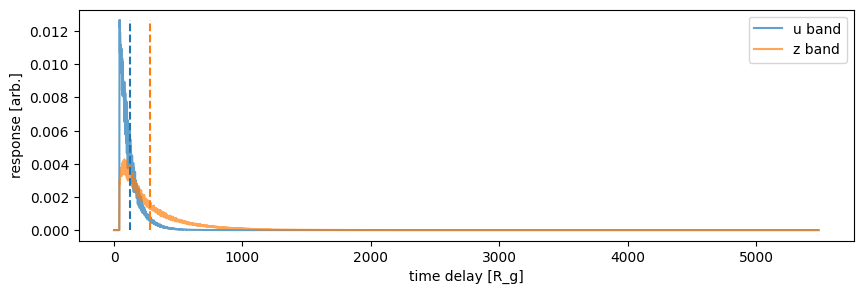

In [11]:
delta_wavelength = 50  # nm, the step size in a downsampled band
filter_u = "lsst2016-u"  # speclite band to use
filter_z = "lsst2016-z"
redshift = 0.2  # To convert filter to source plane wavelengths

lsst_filter_response_u = agn_reprocessor.define_passband_response_function(
    filter_u, redshift=redshift, delta_wavelength=delta_wavelength
)
lsst_filter_response_z = agn_reprocessor.define_passband_response_function(
    filter_z, redshift=redshift, delta_wavelength=delta_wavelength
)
mean_u = astro_util.calculate_mean_time_lag(lsst_filter_response_u)
mean_z = astro_util.calculate_mean_time_lag(lsst_filter_response_z)
max_response = np.max([np.max(lsst_filter_response_u), np.max(lsst_filter_response_z)])

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(lsst_filter_response_u, alpha=0.7, label="u band")
ax.plot(lsst_filter_response_z, alpha=0.7, label="z band")
ax.set_xlabel("time delay [R_g]")
ax.set_prop_cycle(None)  # reset color cycle
ax.plot([mean_u, mean_u], [0, max_response], "--")
ax.plot([mean_z, mean_z], [0, max_response], "--")

ax.legend()
ax.set_ylabel("response [arb.]")
plt.show()

# We can define our own reprocessing kernels using this agn reprocessor as well

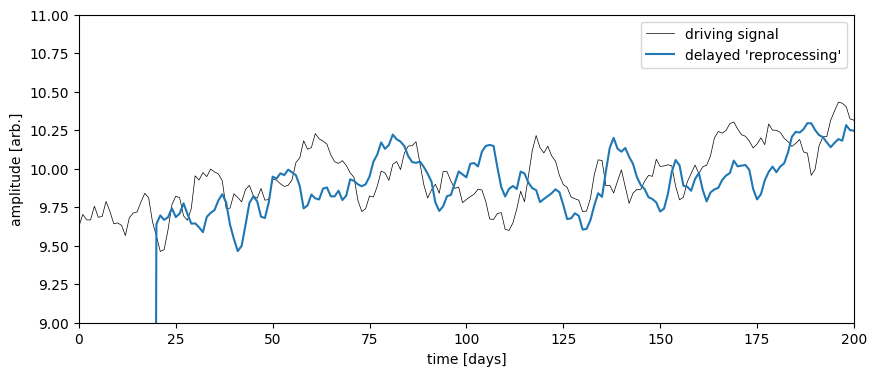

In [12]:
time_lags = np.linspace(0, 25, 25)  # days if defined like this

predefined_kernel = np.zeros(np.shape(time_lags))
predefined_kernel[20] = 1  # define a 20 day delay

reprocessed_signal_with_delay = agn_reprocessor.reprocess_signal(
    response_function_time_lags=time_lags,
    response_function_amplitudes=predefined_kernel,
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_stamps, light_curve, color="black", linewidth=0.5, label="driving signal")
ax.plot(time_stamps, reprocessed_signal_with_delay, label="delayed 'reprocessing'")
ax.set_xlabel("time [days]")
ax.set_ylabel("amplitude [arb.]")
ax.set_xlim(0, 200)  # Note we do not have a 'reprocessed signal' until time = 20 days.
ax.set_ylim(9, 11)
ax.legend()
plt.show()

# Comparing the difference between normal variance in magnitude and amplitude

In [13]:
mean_magnitude = 10
magnitude_variance = -0.4
bpl_kwarg_dict_mag = {
    "length_of_light_curve": length_of_light_curve,
    "time_resolution": dt,
    "log_breakpoint_frequency": log_breakpoint_frequency,
    "low_frequency_slope": low_frequency_index,
    "high_frequency_slope": high_frequency_index,
    "mean_magnitude": mean_magnitude,
    "standard_deviation": magnitude_variance,
    "normal_magnitude_variance": True,
    "seed": random_seed,
}

In [14]:
variable_light_curve = variability.Variability(
    variability_model="bending_power_law", **bpl_kwarg_dict_mag
)

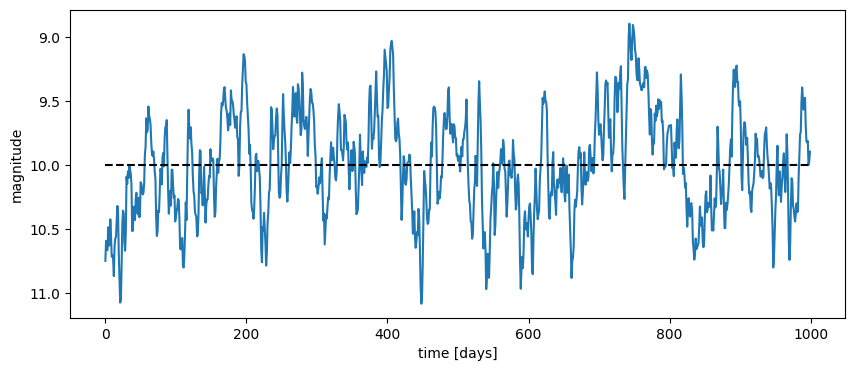

In [15]:
time_axis = np.linspace(0, 999, 1000)
magnitude_light_curve = variable_light_curve.variability_at_time(time_axis)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_axis, magnitude_light_curve)
ax.plot(
    [time_axis[0], time_axis[-1]], [mean_magnitude, mean_magnitude], "--", color="black"
)
ax.invert_yaxis()
ax.set_xlabel("time [days]")
ax.set_ylabel("magnitude")
plt.show()

# Creating a signal with normal flux variance

In [16]:
mean_magnitude = 10
magnitude_variance_lognormal = 0.4
bpl_kwarg_dict_mag_lognormal = {
    "length_of_light_curve": length_of_light_curve,
    "time_resolution": dt,
    "log_breakpoint_frequency": log_breakpoint_frequency,
    "low_frequency_slope": low_frequency_index,
    "high_frequency_slope": high_frequency_index,
    "mean_magnitude": mean_magnitude,
    "standard_deviation": magnitude_variance_lognormal,
    "normal_magnitude_variance": False,
    "seed": random_seed,
}

In [17]:
variable_light_curve_lognormal = variability.Variability(
    variability_model="bending_power_law", **bpl_kwarg_dict_mag_lognormal
)

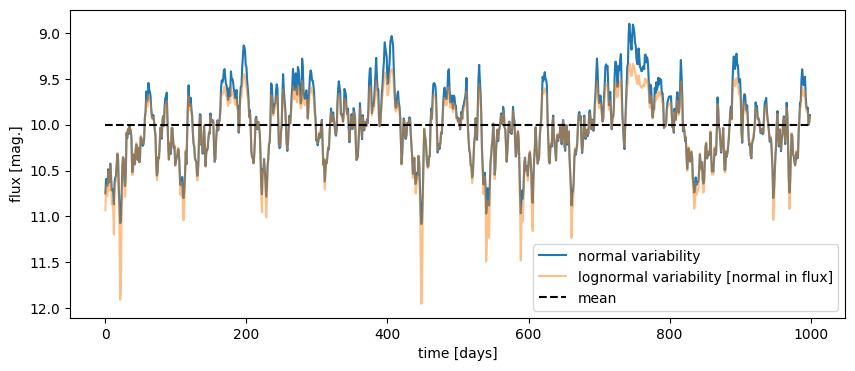

In [18]:
time_axis = np.linspace(0, 999, 1000)
magnitude_light_curve = variable_light_curve.variability_at_time(time_axis)
magnitude_light_curve_lognormal = variable_light_curve_lognormal.variability_at_time(
    time_axis
)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_axis, magnitude_light_curve, label="normal variability")
ax.plot(
    time_axis,
    magnitude_light_curve_lognormal,
    label="lognormal variability [normal in flux]",
    alpha=0.5,
)
ax.plot(
    [time_axis[0], time_axis[-1]],
    [mean_magnitude, mean_magnitude],
    "--",
    color="black",
    label="mean",
)
ax.invert_yaxis()
ax.set_xlabel("time [days]")
ax.set_ylabel("flux [mag.]")
ax.legend()
plt.show()

Note that by converting fluctuations into amplitudes suppresses the brighter fluctuations and accentuates dimmer fluctuations. 

# Calculate many reprocessed signals from a single driving light curve

### Define parameters of simulation

In [19]:
# AGN parameters
outer_radius_of_accretion_disk = 2000  # R_g = G M_bh / c^2
corona_height = 0  # R_g
r_resolution = 1000  # pixels per outer radius
inclination_angle = 1  # degrees
black_hole_mass_exponent = 9.0
# Note that if M_BH <= 10^7 M_sun, outer radius must be >= 3k R_g to build a transfer function long enough.
black_hole_spin = 0.3
eddington_ratio = 0.15
redshift = 1.0
# driving signal parameters
length_of_light_curve = 1000  # Days
dt = 1  # Days
random_seed = 14
low_frequency_index = 1
high_frequency_index = 3
log_breakpoint_frequency = -1
mean_magnitude = 10
magnitude_variance = -0.4
normal_magnitude_variance = True
driving_variability_model = "bending_power_law"

### For LSST bands

In [20]:
bands = [
    "lsst2016-u",
    "lsst2016-g",
    "lsst2016-r",
    "lsst2016-i",
    "lsst2016-z",
    "lsst2016-y",
]
kwarg_dictionary = {
    "r_out": outer_radius_of_accretion_disk,
    "corona_height": corona_height,
    "r_resolution": r_resolution,
    "inclination_angle": inclination_angle,
    "black_hole_mass_exponent": black_hole_mass_exponent,
    "black_hole_spin": black_hole_spin,
    "eddington_ratio": eddington_ratio,
    "redshift": redshift,
    "length_of_light_curve": length_of_light_curve,
    "time_resolution": dt,
    "log_breakpoint_frequency": log_breakpoint_frequency,
    "low_frequency_slope": low_frequency_index,
    "high_frequency_slope": high_frequency_index,
    "mean_magnitude": mean_magnitude,
    "standard_deviation": magnitude_variance,
    "normal_magnitude_variance": normal_magnitude_variance,
    "seed": random_seed,
    "driving_variability_model": driving_variability_model,
    "delta_wavelength": 50,
    "speclite_filter": bands,
}
many_variable_light_curves = variability.Variability(
    "lamppost_reprocessed", **kwarg_dictionary
)

In [21]:
time_stamps = np.linspace(50, 1000, 750)
light_curves = many_variable_light_curves.variability_at_time(time_stamps)

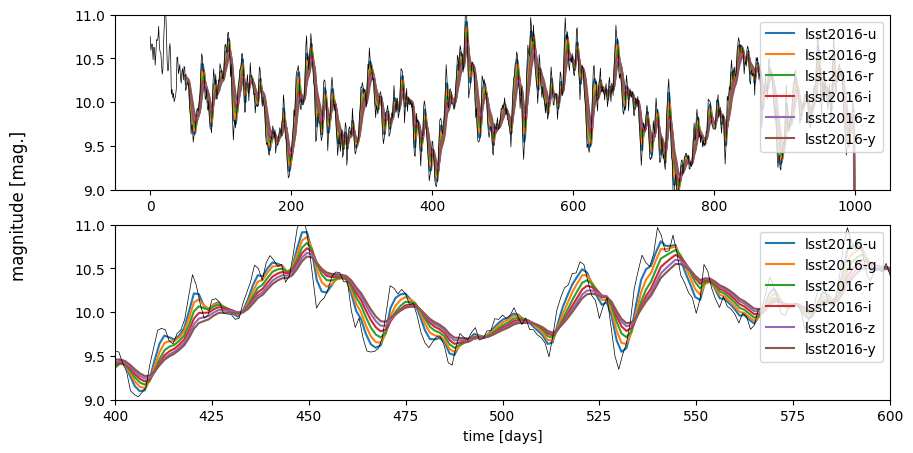

In [22]:
fig, ax = plt.subplots(2, figsize=(10, 5))

for axis in ax:
    for jj in light_curves:
        axis.plot(time_stamps, light_curves[jj], label=jj)
    axis.plot(time_axis, magnitude_light_curve, color="black", linewidth=0.5)
    axis.set_ylim(9, 11)
    axis.legend(loc=1)
ax[1].set_xlabel("time [days]")
fig.supylabel("magnitude [mag.]")
ax[1].set_xlim(400, 600)  # zoom in to see some features
plt.show()

### For observer frame wavelengths

In [23]:
observer_frame_wavelength_in_nm = [100, 200, 500, 1000, 2000]
kwarg_dictionary_obs = {
    "r_out": outer_radius_of_accretion_disk,
    "corona_height": corona_height,
    "r_resolution": r_resolution,
    "inclination_angle": inclination_angle,
    "black_hole_mass_exponent": black_hole_mass_exponent,
    "black_hole_spin": black_hole_spin,
    "eddington_ratio": eddington_ratio,
    "redshift": redshift,
    "length_of_light_curve": length_of_light_curve,
    "time_resolution": dt,
    "log_breakpoint_frequency": log_breakpoint_frequency,
    "low_frequency_slope": low_frequency_index,
    "high_frequency_slope": high_frequency_index,
    "mean_magnitude": mean_magnitude,
    "standard_deviation": magnitude_variance,
    "normal_magnitude_variance": normal_magnitude_variance,
    "seed": random_seed,
    "driving_variability_model": driving_variability_model,
    "delta_wavelength": 50,
    "obs_frame_wavelength_in_nm": observer_frame_wavelength_in_nm,
}
many_variable_light_curves_obs = variability.Variability(
    "lamppost_reprocessed", **kwarg_dictionary_obs
)
time_stamps = np.linspace(50, 1000, 750)
light_curves = many_variable_light_curves_obs.variability_at_time(time_stamps)

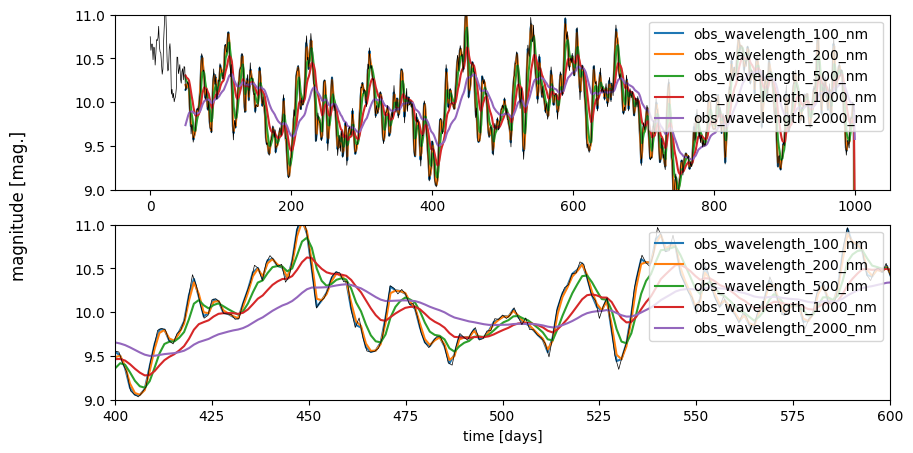

In [24]:
fig, ax = plt.subplots(2, figsize=(10, 5))

for axis in ax:
    for jj in light_curves:
        axis.plot(time_stamps, light_curves[jj], label=jj)
    axis.plot(time_axis, magnitude_light_curve, color="black", linewidth=0.5)
    axis.set_ylim(9, 11)
    axis.legend(loc=1)
ax[1].set_xlabel("time [days]")
fig.supylabel("magnitude [mag.]")
ax[1].set_xlim(400, 600)  # zoom in to see some features
plt.show()

### For rest frame wavelengths

In [25]:
rest_frame_wavelength_in_nm = [100, 200, 500, 1000, 2000]
kwarg_dictionary_obs = {
    "r_out": outer_radius_of_accretion_disk,
    "corona_height": corona_height,
    "r_resolution": r_resolution,
    "inclination_angle": inclination_angle,
    "black_hole_mass_exponent": black_hole_mass_exponent,
    "black_hole_spin": black_hole_spin,
    "eddington_ratio": eddington_ratio,
    "redshift": redshift,
    "length_of_light_curve": length_of_light_curve,
    "time_resolution": dt,
    "log_breakpoint_frequency": log_breakpoint_frequency,
    "low_frequency_slope": low_frequency_index,
    "high_frequency_slope": high_frequency_index,
    "mean_magnitude": mean_magnitude,
    "standard_deviation": magnitude_variance,
    "normal_magnitude_variance": normal_magnitude_variance,
    "seed": random_seed,
    "driving_variability_model": driving_variability_model,
    "delta_wavelength": 50,
    "rest_frame_wavelength_in_nm": rest_frame_wavelength_in_nm,
}
many_variable_light_curves_obs = variability.Variability(
    "lamppost_reprocessed", **kwarg_dictionary_obs
)
time_stamps = np.linspace(50, 1000, 750)
light_curves = many_variable_light_curves_obs.variability_at_time(time_stamps)

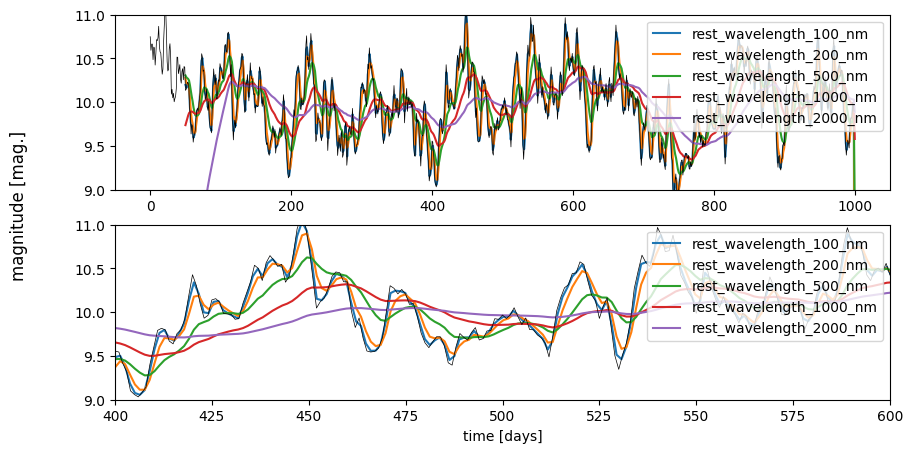

In [26]:
fig, ax = plt.subplots(2, figsize=(10, 5))

for axis in ax:
    for jj in light_curves:
        axis.plot(time_stamps, light_curves[jj], label=jj)
    axis.plot(time_axis, magnitude_light_curve, color="black", linewidth=0.5)
    axis.set_ylim(9, 11)
    axis.legend(loc=1)
ax[1].set_xlabel("time [days]")
fig.supylabel("magnitude [mag.]")
ax[1].set_xlim(400, 600)  # zoom in to see some features
plt.show()

### And finally, for a mixed batch of rest/observed wavelengths and filters

In [27]:
rest_frame_wavelength_in_nm = [100, 300, 1000]
obs_frame_wavelength_in_nm = 300
speclite_filter = ["lsst2016-g", "lsst2016-r", "lsst2016-y"]
kwarg_dictionary_mix = {
    "r_out": outer_radius_of_accretion_disk,
    "corona_height": corona_height,
    "r_resolution": r_resolution,
    "inclination_angle": inclination_angle,
    "black_hole_mass_exponent": black_hole_mass_exponent,
    "black_hole_spin": black_hole_spin,
    "eddington_ratio": eddington_ratio,
    "redshift": redshift,
    "length_of_light_curve": length_of_light_curve,
    "time_resolution": dt,
    "log_breakpoint_frequency": log_breakpoint_frequency,
    "low_frequency_slope": low_frequency_index,
    "high_frequency_slope": high_frequency_index,
    "mean_magnitude": mean_magnitude,
    "standard_deviation": magnitude_variance,
    "normal_magnitude_variance": normal_magnitude_variance,
    "seed": random_seed,
    "driving_variability_model": driving_variability_model,
    "delta_wavelength": 50,
    "rest_frame_wavelength_in_nm": rest_frame_wavelength_in_nm,
    "obs_frame_wavelength_in_nm": obs_frame_wavelength_in_nm,
    "speclite_filter": speclite_filter,
}
many_variable_light_curves_mix = variability.Variability(
    "lamppost_reprocessed", **kwarg_dictionary_mix
)
time_stamps = np.linspace(50, 1000, 750)
light_curves = many_variable_light_curves_mix.variability_at_time(time_stamps)

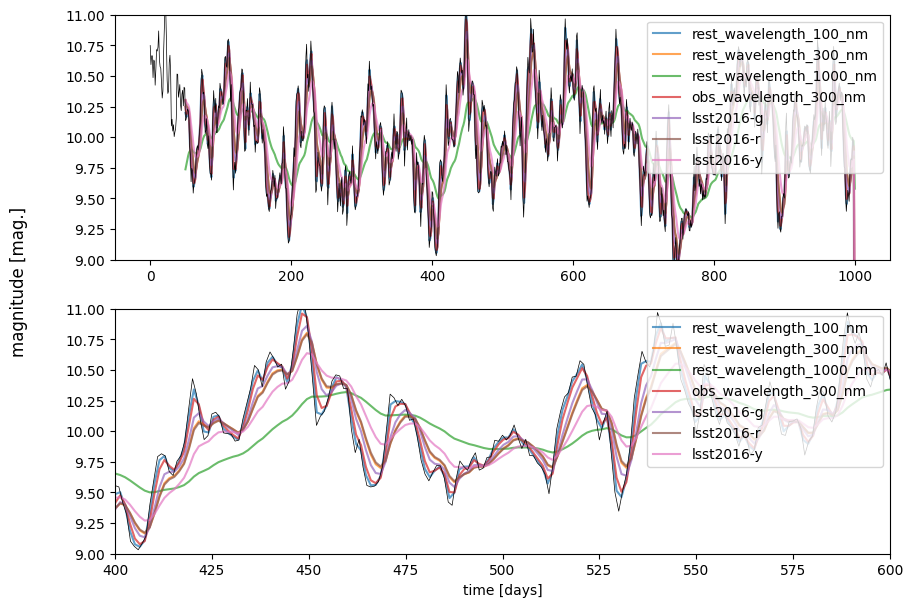

In [28]:
fig, ax = plt.subplots(2, figsize=(10, 7))

for axis in ax:
    for jj in light_curves:
        axis.plot(time_stamps, light_curves[jj], label=jj, alpha=0.7)
    axis.plot(time_axis, magnitude_light_curve, color="black", linewidth=0.5)
    axis.set_ylim(9, 11)
    axis.legend(loc=1)
ax[1].set_xlabel("time [days]")
fig.supylabel("magnitude [mag.]")
ax[1].set_xlim(400, 600)  # zoom in to see some features
plt.show()

## Note that all signals above are in the source plane! 